# Bayesian Modeling and Markov Chain Monte Carlo

### Data Science 350

## Overview

This notebook introduces you to a general and flexible form of Bayesian modeling using the **Makov chain Monte Carlo** methods. 

![](img/Flips.png)


## Review of Bayes Theorem

Bayes theorem allows us 

$$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

This is a bit of a mess. But fortunately, we don't always need the denominator. We can rewrite Bayes Theorem as:

$$𝑃(𝐴│𝐵)=𝑘∙𝑃(𝐵|𝐴)𝑃(𝐴)$$

Ignoring the normalizaton constant $k$, we get:

$$𝑃(𝐴│𝐵) \propto 𝑃(𝐵|𝐴)𝑃(𝐴)$$

### Bayesian parameter estimation

How to we interpret the relationships shown above? We do this as follows:

$$Posterior\ Distribution \propto Likelihood \bullet Prior\ Distribution \\
Or\\
𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠│𝑑𝑎𝑡𝑎) \propto 𝑃(𝑑𝑎𝑡𝑎|𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠)𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠) $$

These relationships apply to the observed data distributions, or to parameters in a model (partial slopes, intercept, error distributions, lasso constant,…). 

### Frequentist by Bayesian models

Let's summarize the differences between the Baysian and Frequentist views. 

- Bayesian methods use priors to quantify what we know about parameters.
- Frequentists do not quantify anything about the parameters, using p-values and confidence intervals to express the unknowns about parameters.

Recalling that both views are useful, we can contrast these methods with a chart.

![](img/FrequentistBayes.jpg)

## Grid Sampling and Scalability

Real-world Bayes models have large numbers of parameters, even into the millions. As a naive approach to Bayesian analysis would be to simply grid sample across the dimensions of the parameter space. However, grid sampling will not scale. To underestand the scaling problem, do the following thought experiment, where each dimension is sampled 100 times:

- For a 1-parameter model: $100$ samples.
- For a 2-parameter model: $100^2 = 10000$ samples.
- For a 3-parameter model: $100^3 = 10^6$ samples.
- For a 100-parameter model: $100^100 = 100^{200}$ samples. 

As you can see, the compuational complexity of grid sampling has **exponential scaling** with dimensionality. Clearly, we need a better approach. 

## Introduction to Markov Chain Monte Carlo

Large-scale Bayesian models use a family of efficient sampling methods known as **Markov chain Monte Carlo sampling**. MCMC methods are compuationally efficient, but requires some effort to understand how it works and  what to do when things go wrong. 

### What is a Markov process?

As you might guess, a MCMC sampling uses a chain of **Markov sampling processes**. The chain is built from a sequence of individul Markov processes. A Markov process is any process that a makes a transition from one state other states with probability $\Pi$ with **no dependency on past states**. In summary, a Markov process has the  following properties:
- $\Pi$  only depends on the current state
- Transition to one or more other states
- Can ‘transition’ to current state
- A matrix $\Pi$ of dim N X N for N possible states
- A Markov procecss is a random walk since any possible transition can occur from each state.

A Markov chain is a sequence of Markov transition processes:

$$P(X_{t + 1}| X_t = x_t, \ldots, x_0 = x_t) = p(X_{t + 1}| x_t)$$

We say the the Markov process is **memoryless**. The transition probability only depends on the current state, not any previous state. 

For a system with $N$ possible states we can write the transition matrix $\Pi$ for the probaility of transition from one state to another:

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1, N}\\
\pi_{2,1} & \pi_{2,2} & \cdots & \pi_{2,N}\\
\cdots & \cdots & \cdots & \cdots \\
\pi_{N,i} & \pi_{N,2} & \cdots & \pi_{N,N}
\end{bmatrix}\\
where\\
\pi_{i,j} = probability\ of\ transition\ from\ state\ i\ to state\ j\\
and\\
\pi_{i,i} = probability\ of\ staying\ in\ state\ i\\
further\\
\pi_{i,j} \ne \pi_{j,i}\ in\ general
$$

Notice that none of these probabilities depend on the previous state history.

### MCMC and the Metropolis Algorithm

The first MCMC sampling algorithm is the **Metropolis Hastings algorithm** (Metropolis et al. (1953), Hastings (1970)). This algorithm is often referred to as the Metropolis algorithm. The Metropolis algorithm has the following steps to estimate the density of the likelihood of the parameters:
1. Pick a starting point in your parameter space and evaluate the posterior according to your model. In other words, take an initial sample of the likelihood $p(data|parameters)$.
2. Choose a nearby point in parameter space randomly and evaluate the likelihood at this point.
  - If the $p(data | parameters)$ of the new point is greater than your current point, accept new point and move there.
  - If the $p(data | parameters)$ of the new point is less than your current point, only accept with probability according to the ratio:  
$$Acceptance\ probability\ = \frac{p(data | new\ parameters)}{p(data | previous\ parameters)}$$.
3. Repeat step 2 many times.


Now that we have outlined the basic Metropolois MCMC algorithm, let's examine some of its properties.

- Since the M-H algorithm samples the parameter space we only need to visit a limited number of points, ratherthann sample an entire grid. 
- The M-H algorithm is guaranteed to **eventually converge** to the underlying distribution.
- If there is high serial correlation from one sample to the next in M-H chain converges slowly. 
- To ensure efficient convergence we Need to ‘tune’ the state selection probability distribution used to find the next point. For example if we use Normal distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, there are large jumps which slow convergence

### M-H algorithm example

Let's make these concepts concrete, let's try a simple example.

As a first step, lets plot a set of points with density determined by the a bi-variate Normal distribution. Execute the code below and examine the resulting plot.

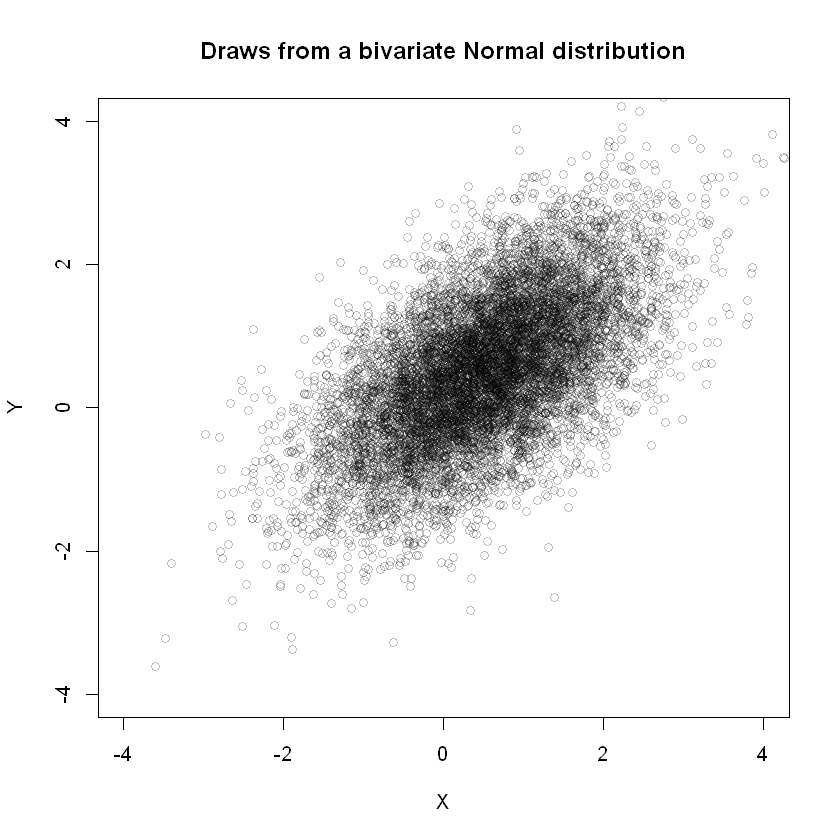

In [26]:
library(MASS)
random_points = mvrnorm(10000, mu=c(0.5,0.5), Sigma=matrix(c(1,0.6,0.6,1), nrow=2))
plot(random_points[,1], random_points[,2], xlim=c(-4,4), ylim=c(-4,4), col=rgb(0,0,0,0.25),
     main = 'Draws from a bivariate Normal distribution', 
    xlab = 'X', ylab = 'Y')

This plot looks as expected. The density of the dots is proportional to the probabilities. You can see the effect of the covariance structure in these data.

As a next step, let's look at the density of the marginal probabilites of the $X$ and $Y$ variables. The code in the cell below plots histogram and density plots of the marginals. Execute this code and examine the result. 

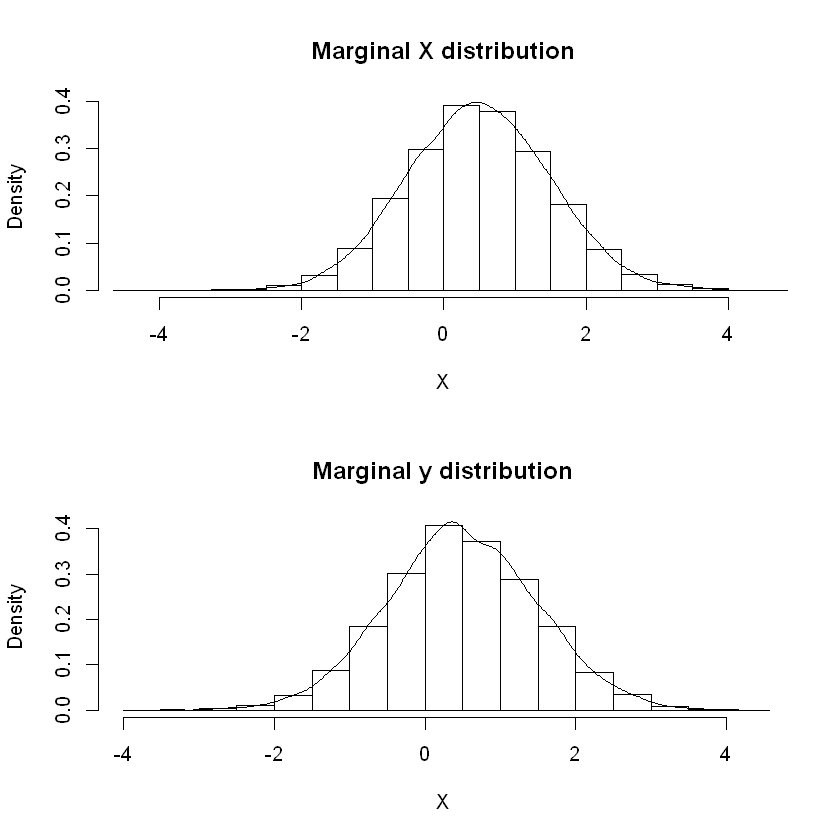

In [2]:
par(mfrow = c(2,1))
hist(random_points[,1], freq = FALSE,
     main = 'Marginal X distribution', 
     xlab = 'X')
lines(density(random_points[,1]))
hist(random_points[,2], freq = FALSE,
     main = 'Marginal Y distribution', 
     xlab = 'Y') 
lines(density(random_points[,2]))
par(mfrow = c(1,1))

You can see that these distributions are approimately Normal, but with a right skew. 

Now, we are ready to sample these data using the M-H MCMC algorithm. The code in the cell below performs the following operations:

1. Compute the likelihood of the bi-variate Normal distribution. 
2. Initialize the chain.
3. Initialize some performance statistics.
4. Sample the likelihood of the data using the M-H algorithm.
5. Plot the result.

Execute this code and examine the result. 

7.446816e-19


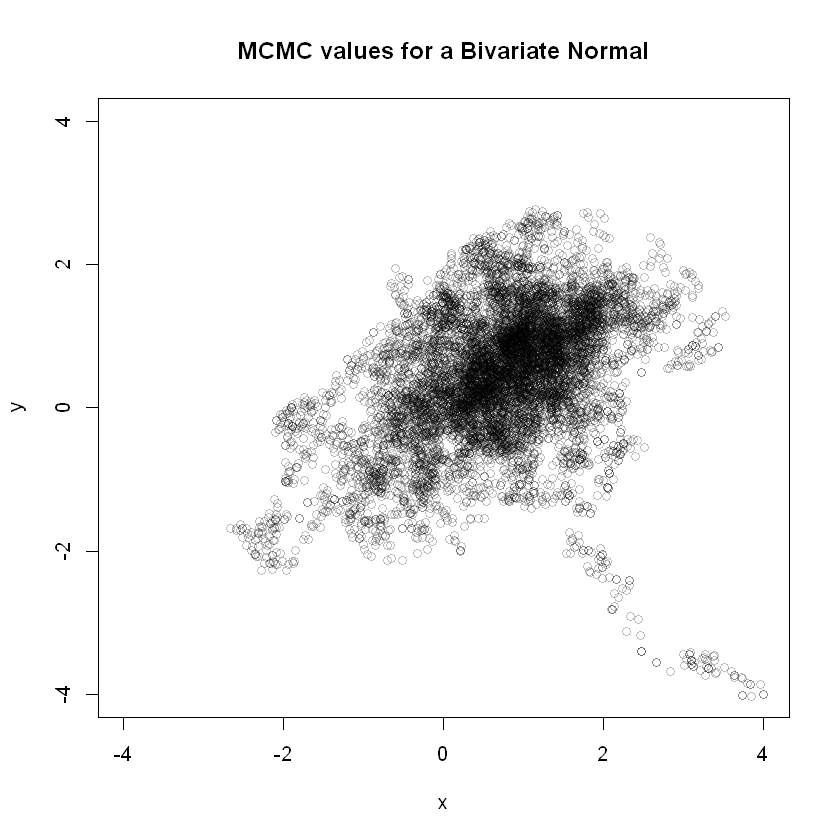

In [3]:
# Given a point, our value at that point(x,y) will be the 
# value of the distribution at x,y:
likelihood = function(x,y){
  sigma = matrix(c(1,0.6,0.6,1), nrow=2)
  mu = c(0.5,0.5)
  dist = c(x,y) - mu
  value = (1/sqrt(4*pi^2**det(sigma))) * exp((-1/2) * t(dist) %*% ginv(sigma) %*% t(t(dist)) )
  return(value)
}

# Where to start:
x_chain = 4
y_chain = -4
# Chain length:
chain_length = 10000

#Evaluate current position:
current_val = likelihood(x_chain,y_chain)
current_val

# Standard deviation of how far out to propose:
proposal_sd = .1

# Keep track of things:
accept_count = 0
reject_count = 0


for (n in 1:(chain_length-1)){ # chain length minus 1 because we already have a point (the starting point)
  proposed_x = x_chain[n] + rnorm(1, mean=0, sd=proposal_sd)
  proposed_y = y_chain[n] + rnorm(1, mean=0, sd=proposal_sd)
  proposed_val = likelihood(proposed_x, proposed_y)
  
  # Accept according to probability:
  if (runif(1) < (proposed_val/current_val)){
    x_chain = c(x_chain, proposed_x)
    y_chain = c(y_chain, proposed_y)
    current_val = proposed_val
    accept_count = accept_count + 1
  }else{
    x_chain = c(x_chain, x_chain[n])
    y_chain = c(y_chain, y_chain[n])
    reject_count = reject_count + 1
  } 
}

plot(x_chain, y_chain, col=rgb(0,0,0,0.25), xlim=c(-4,4), ylim=c(-4,4),
     main="MCMC values for a Bivariate Normal", xlab="x", ylab="y")


Notice the long 'tail' on the sampled distribution. This behavior arrises from the initial wandering of the Markov chain as it finds the high probability regions of the distribution. This period in which the Markov chain wanders is known as the **burn-in period**.

The code in the cell below, plots the same Markov chain, but with the first 1000 values removed. The remaining samples are from the post burn-in chain. 

[1] 1000

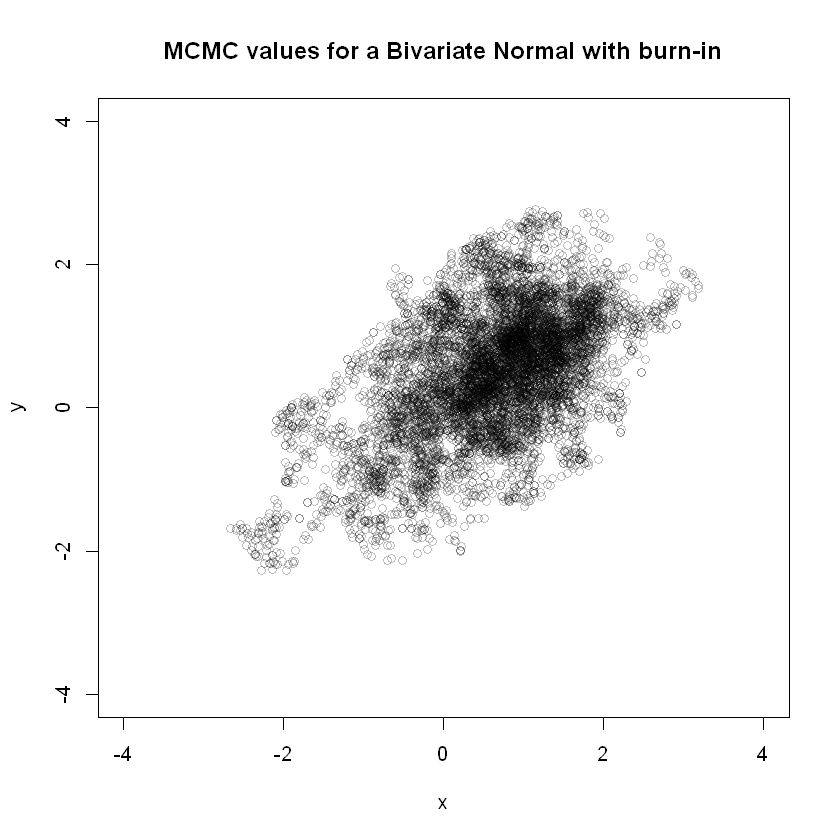

In [4]:
# Burn in problem.  Solution?  Throw away first part of chain.
num_burnin = round(0.1*chain_length)
num_burnin

plot(x_chain[num_burnin:chain_length], y_chain[num_burnin:chain_length],
     col=rgb(0,0,0,0.25), xlim=c(-4,4), ylim=c(-4,4),
     main="MCMC values for a Bivariate Normal with burn-in", xlab="x", ylab="y")

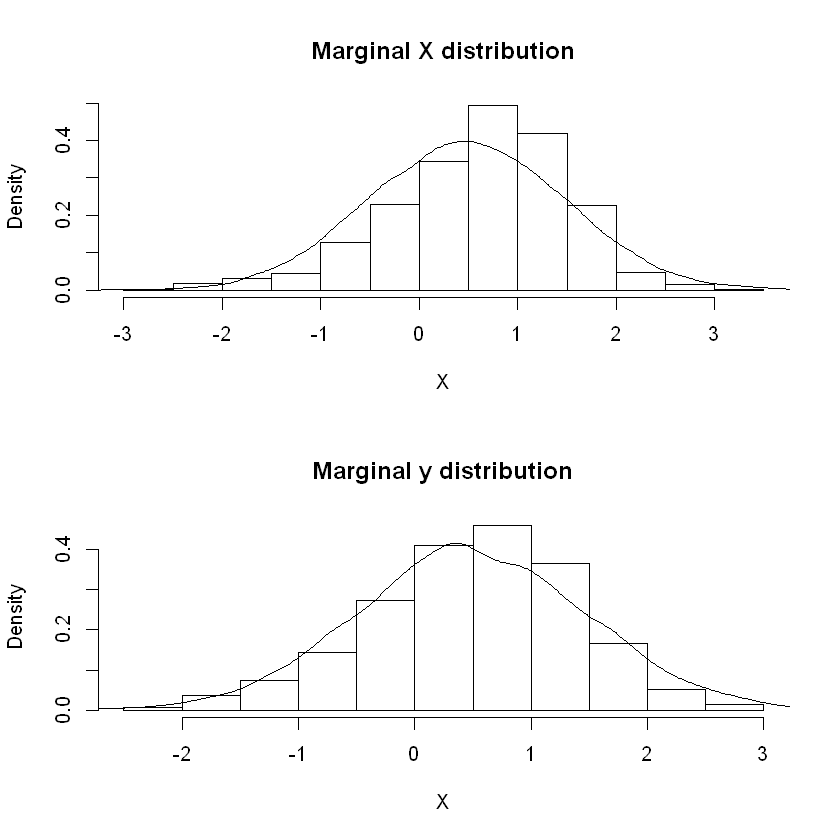

In [5]:
par(mfrow = c(2,1))
hist(x_chain[num_burnin:chain_length], freq = FALSE,
     main = 'Marginal X distribution', 
     xlab = 'X')
lines(density(random_points[,1]))
hist(y_chain[num_burnin:chain_length], freq = FALSE,
     main = 'Marginal y distribution', 
     xlab = 'X') 
lines(density(random_points[,2]))
par(mfrow = c(1,1))

In [6]:
# Estimate bivariate MAP from chain:
mcmc_map = c(mean(x_chain), mean(y_chain))
mcmc_map

[1] 0.7094135 0.4527466

In [7]:
# Acceptance/Reject rate:
cat('Acceptance rate =', accept_count/chain_length, '\n')
cat('Rejection rate =', reject_count/chain_length, '\n')

Acceptance rate = 0.9388 
Rejection rate = 0.0611 


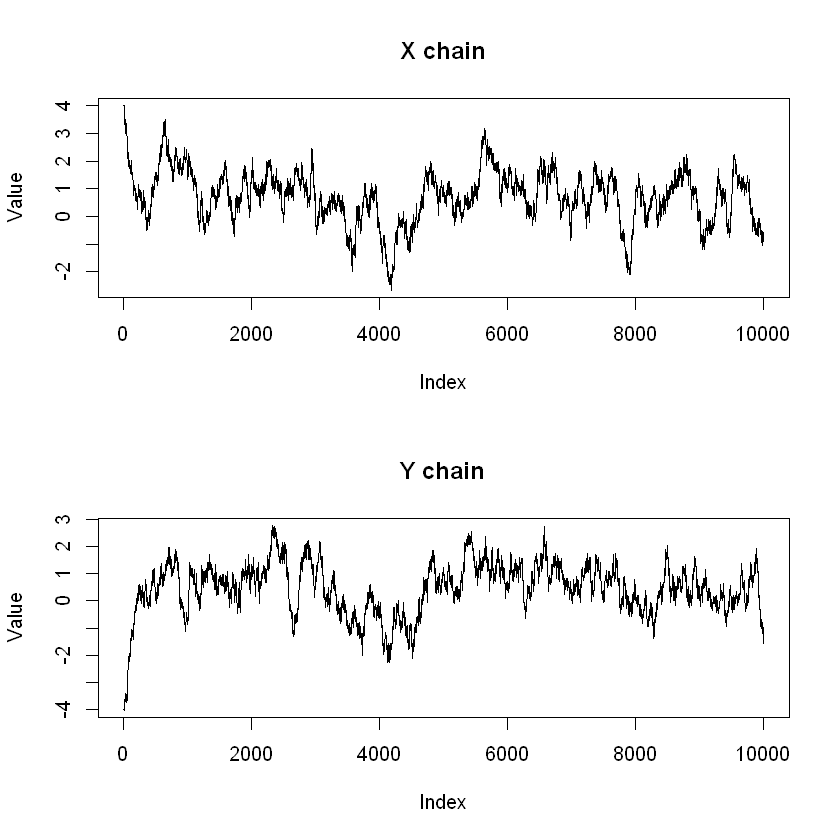

In [8]:
# Always look at the chain, we would like random noise centered around means
par(mfrow = c(2,1))
plot(x_chain, type="l", main = 'X chain', ylab = 'Value')
plot(y_chain, type="l", main = 'Y chain', ylab = 'Value')
par(mfrow = c(1,1))

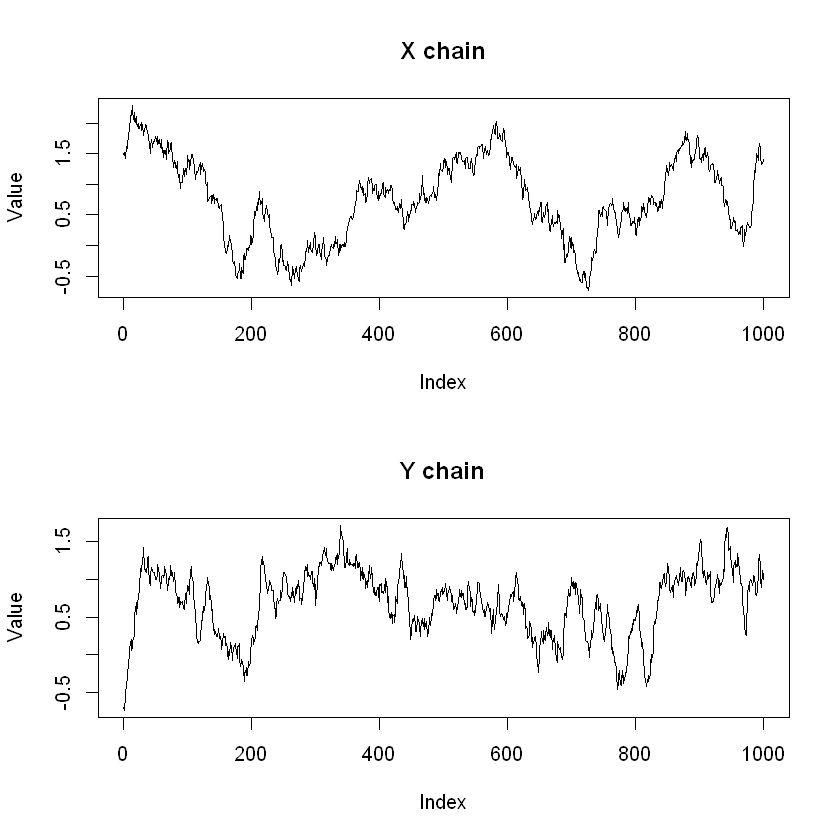

In [9]:
## Look at a shorter segment of the chain
# Always look at the chain, we would like random noise centered around means
par(mfrow = c(2,1))
plot(x_chain[1000:2000], type="l", main = 'X chain', ylab = 'Value')
plot(y_chain[1000:2000], type="l", main = 'Y chain', ylab = 'Value')
par(mfrow = c(1,1))

## Gibbs Sampling

The Metropolis Hastings algorithm is a useful tool. However, this algorithm can suffer from slow convergence for several reasons:

- Samples from the M-H algorithm generally have a fairly high serial correlation. This is a result from taking steps in random directions.
- As already mentioned, we need to ‘tune’ the state selection probability distribution used to find the next point. For example if we use Normal distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, there are large jumps which slow convergence.

The Gibbs sampler (Geman and Geman, 1984) is an improved MCMC sampler which speeds convergance. The basic Gibbs sampler algorithm has the following steps:

1. For an N dimensional parameter space, $\{ \theta_1, \theta_2, \ldots, \theta_N \}$, find a random starting point. 
2. Starting with dimension $1$, cycle through each dimension in order, $\{1, 2, 3, \ldots, N\}$:  
  - Sample the marginal distribution of the parameter based on the probability distribution of the parmaeter given the data and other parameter values:
  $$p(\theta_1|D, \theta_2, \theta_3, \ldots, \theta_N)\\ 
  where\\
  D\ is\ the\ data$$
  - Repeat this sampling proceedure for each remaining dimension in order, $\{2, 3, \ldots, N\}$.
4. Repeat step 2 until convergance.    

From this simplifed description of the Gibbs sampling algorithm you can infer:

- When compared to the Metropolis-Hastings algorithm, the Gibbs sampler reduces serial correlation owing to the reduced round-robin nature of the sampling.   
- There are no tuning parameters since sampling is based on the marginals of the likelihood.

### Gibbs sampler example

Let's try a simple example of a Bayes model using Gibbs sampled MCMC. 

In this case, we will under take a univariate regression problem using synthetic data. As a first step the code in the cell below generates bi-variate data with Normally distributed errors and plots the result. Execute this code to compute the data.     

Loading required package: rjags
Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


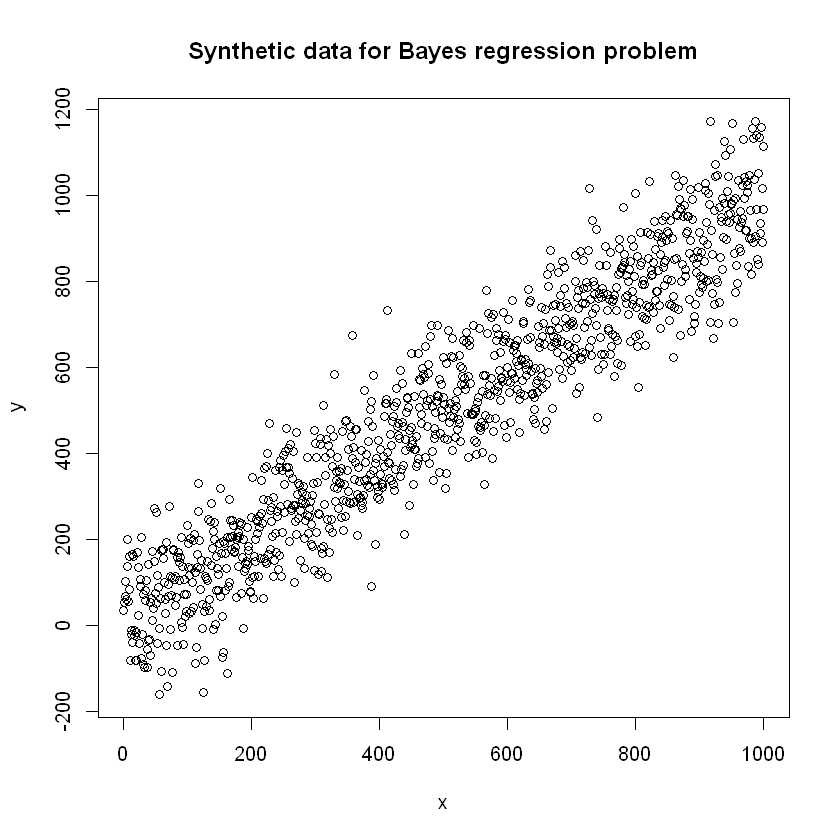

In [10]:
## Set up the data set as a regression problem
require('rjags')
N <- 1000
x <- 1:N
epsilon <- rnorm(N, 0, 100)
y <- x + epsilon

plot(x, y, main = 'Synthetic data for Bayes regression problem')

The regression model has two parameters, a slope and an intercept, which we will call $a$ and $b$. We will use a **hierarchical Bayes model**. The model is considered hierarchical since the quantity we really want to know, the posterior distribution of the label, which we will refer to as $\hat{y}$, depends on the distribution of other model parameters. In this case, the posterior distribution of $\hat{y}$ depends on both the regression coeficients and an error term. We can visualize the hierarchical relationships in this model in the diagram below.

![](img/HierarchicalModel.jpg)
<center> **Hierarchical model for the posterior distribution of y** </center>

In mathematical terms we can define the hierarchical model as follows:
 
1. The prior of the dispursion, $\sigma$, of the Power distribution is defined as the Uniform distribution:
$$U(0, 100)$$
2. The variance (dispersion) of the label values is modeled as an Power distribution:
$$\tau = a x^\sigma = -2 x^\sigma$$
3. The prior distributions of the regression model, $a$ and $b$, are modeled as Normal distributions:
$$N(0, 0.01)$$
4. The regression model for estimating $\hat{y_i}$ is defined by:
$$\hat{y_i} = a + b x_i$$
5. The posterior distribution of the label values is modeled as a Normal distribution:
$$N(\hat{y_i}, \tau)$$

To compute the MCMC samples we will use the JAGS (Just Another Gibbs Sampler) package. JAGS is a multi-platform derivative of the BUGS language (Bayesian inference Using Gibbs Sampling), and is based on the BUGS language. 

The JAGS model is defined in the `example.bugs` file. The model model definition in this file is shown here:

```
model
{
	for (i in 1:N)
	{
		y[i] ~ dnorm(y.hat[i], tau)
		y.hat[i] <- a + b * x[i]
	}
	a ~ dnorm(0, .01)
	b ~ dnorm(0, .01)
	tau <- pow(sigma, -2)
	sigma ~ dunif(0, 100)
}
```

Notice that the model definition in the BUGS lanuage works from the bottom of the heirarchy up. 

With the model defined we need to execute it using `rjags` package. This package orchestrates the execution of JAGS models from R. The cell below contains the code to compile our JAGS model. The `jags.model` function requires the following arguments:

1. The path to the .bugs file.
2. A list with the data, x, y, and the number of cases.
3. The number of chains to use for the MCMC sampling.
4. The number 'burn-in' samples.

Execute this code to compile and run the model.

In [11]:
## Run the jags model
path = 'C:\\Users\\StevePC2\\Documents\\Git\\DataScience350\\Lecture9' # SET YOUR PATH HERE!!
full.path = file.path(path, 'example.bug')
jags.mod.reg <- jags.model(full.path,
                   data = list('x' = x,
                               'y' = y,
                               'N' = N),
                   n.chains = 4,
                   n.adapt = 1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1000
   Unobserved stochastic nodes: 3
   Total graph size: 4013

Initializing model



Mark the 

In [12]:
## Compute some samples
samples <- coda.samples(jags.mod.reg,
                        c('a', 'b'),
                        1000)

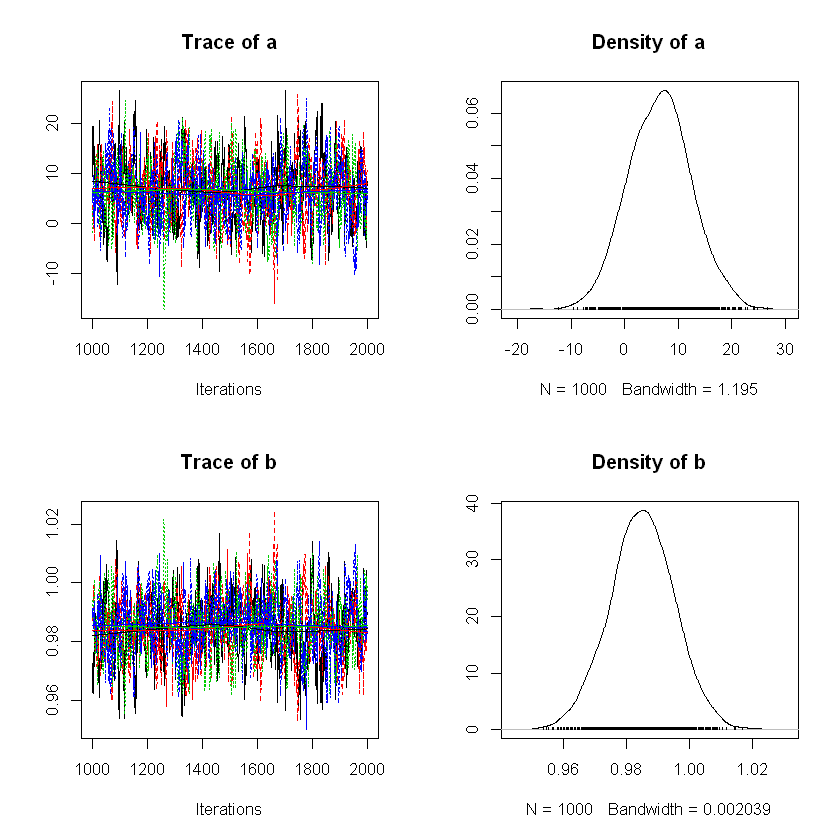

In [13]:
library(coda)
plot(samples) # Plot the result

In [14]:
summary(samples) # Summary statistics


Iterations = 1001:2000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

    Mean      SD  Naive SE Time-series SE
a 6.5786 5.93260 0.0938027      0.2505097
b 0.9849 0.01022 0.0001615      0.0004273

2. Quantiles for each variable:

     2.5%    25%    50%     75%  97.5%
a -4.7609 2.5306 6.6208 10.4650 18.506
b  0.9648 0.9782 0.9849  0.9917  1.005


In [15]:
lm.mod = lm(y ~ x, data = data.frame(x = x, y = y))
summary(lm.mod)


Call:
lm(formula = y ~ x, data = data.frame(x = x, y = y))

Residuals:
    Min      1Q  Median      3Q     Max 
-295.67  -71.49    0.74   66.88  319.56 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.41922    6.16301   1.042    0.298    
x            0.98523    0.01067  92.365   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 97.37 on 998 degrees of freedom
Multiple R-squared:  0.8953,	Adjusted R-squared:  0.8952 
F-statistic:  8531 on 1 and 998 DF,  p-value: < 2.2e-16


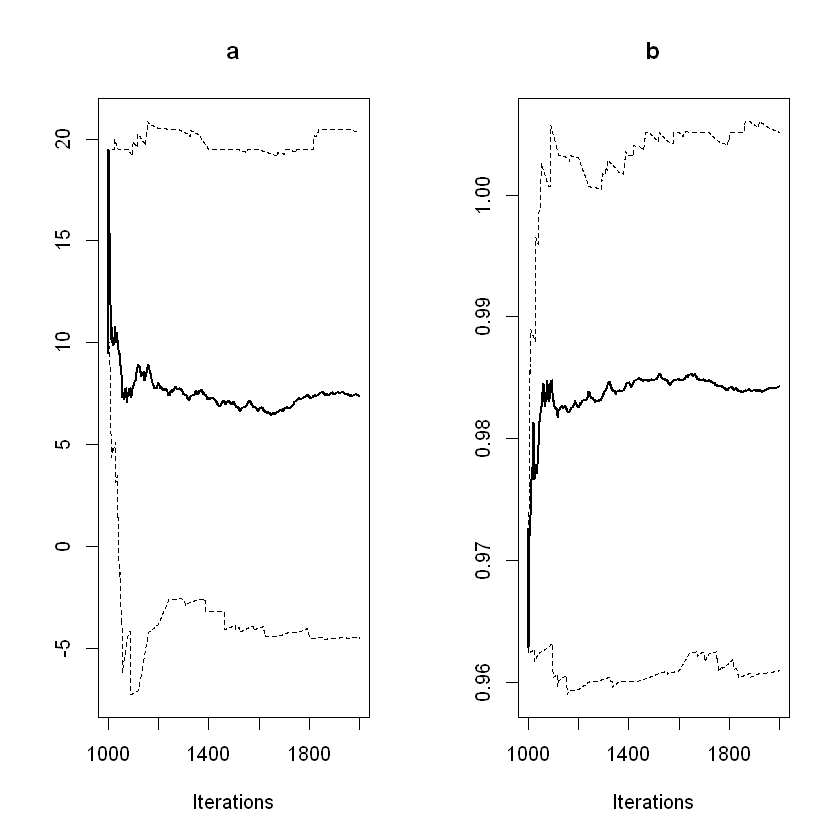

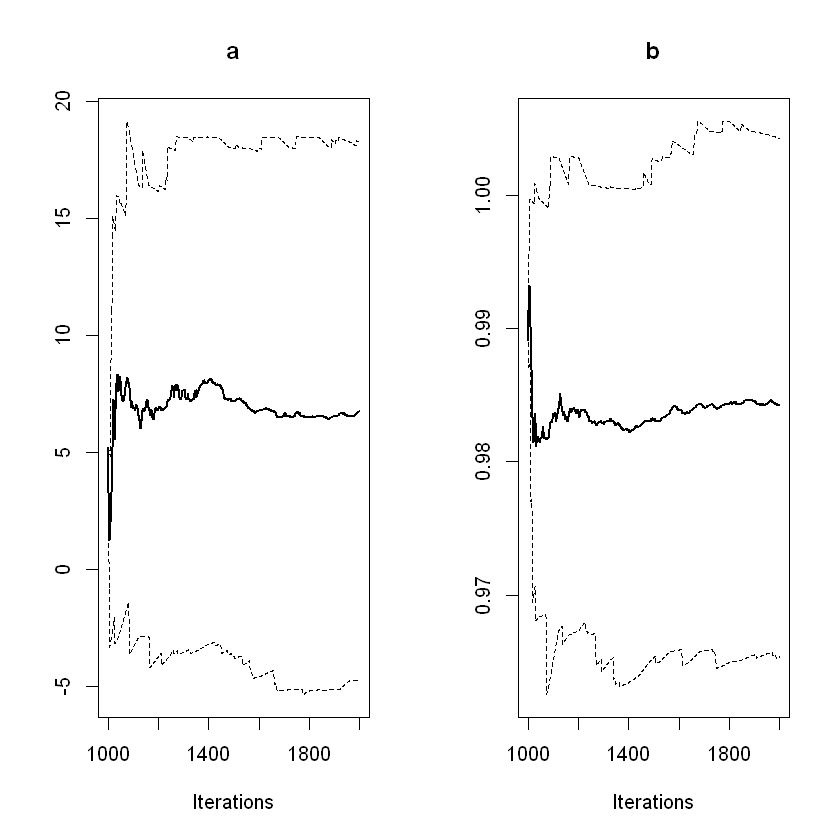

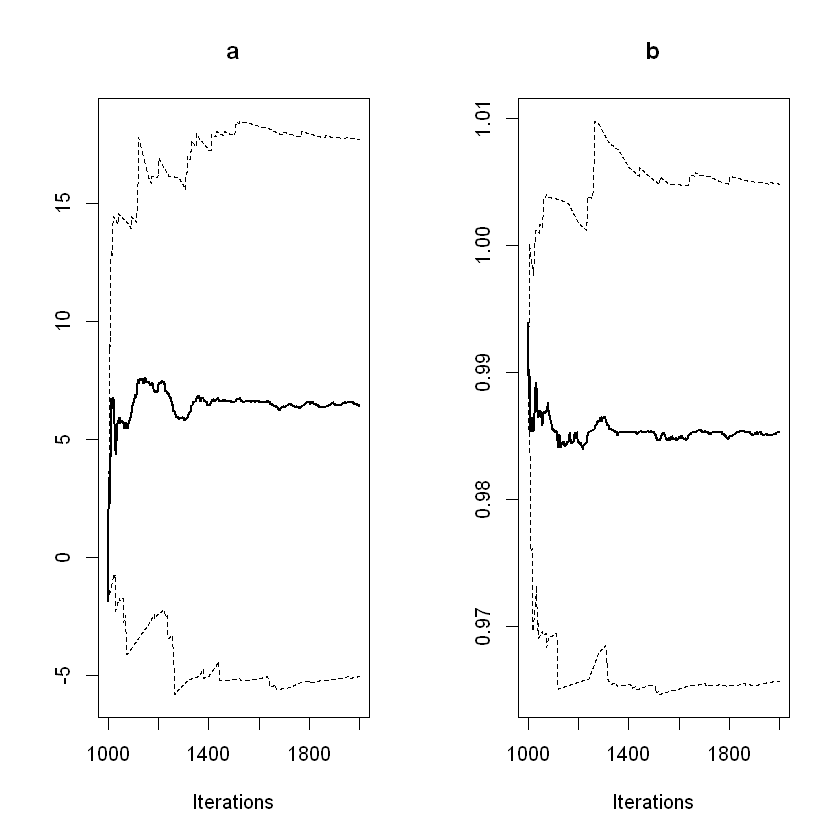

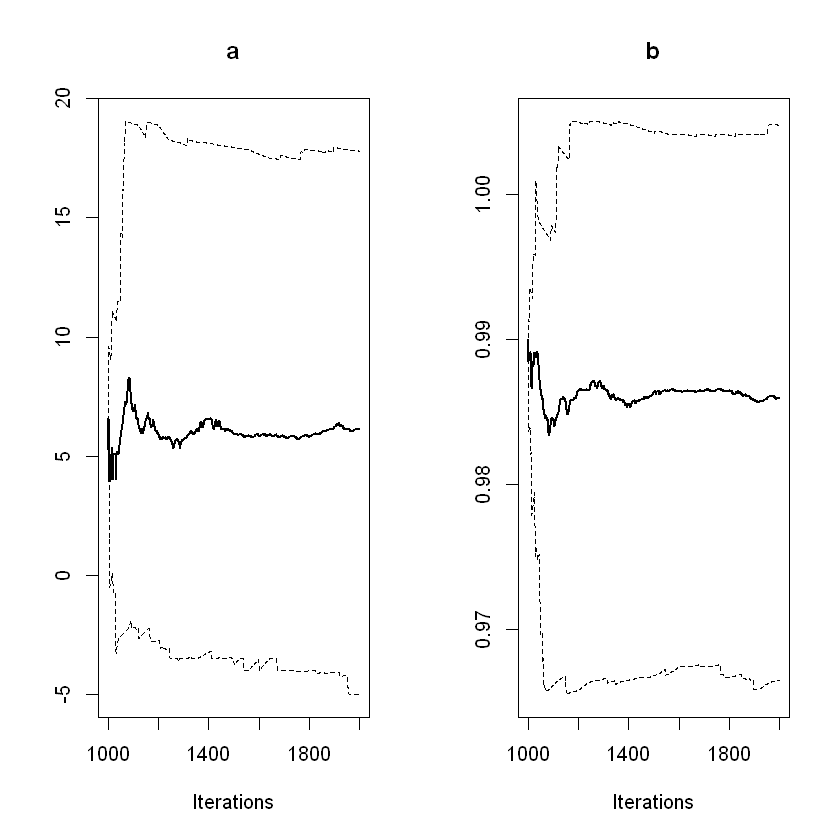

In [16]:
cumuplot(samples) # Cumulative mean for each chain

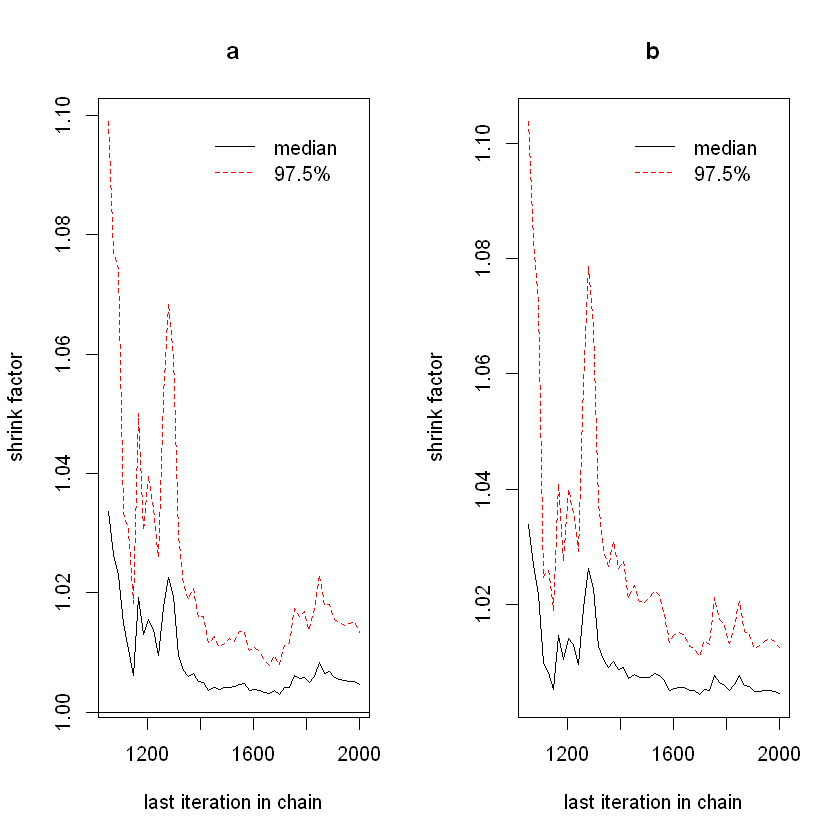

In [17]:
gelman.plot(samples) # Gelman convergence plot

,a,b
Lag 0,1.00000000,1.00000000
Lag 1,0.74614968,0.73709584
Lag 5,0.26526377,0.26594428
Lag 10,0.07622555,0.08783863
Lag 50,-0.05612954,-0.06877748


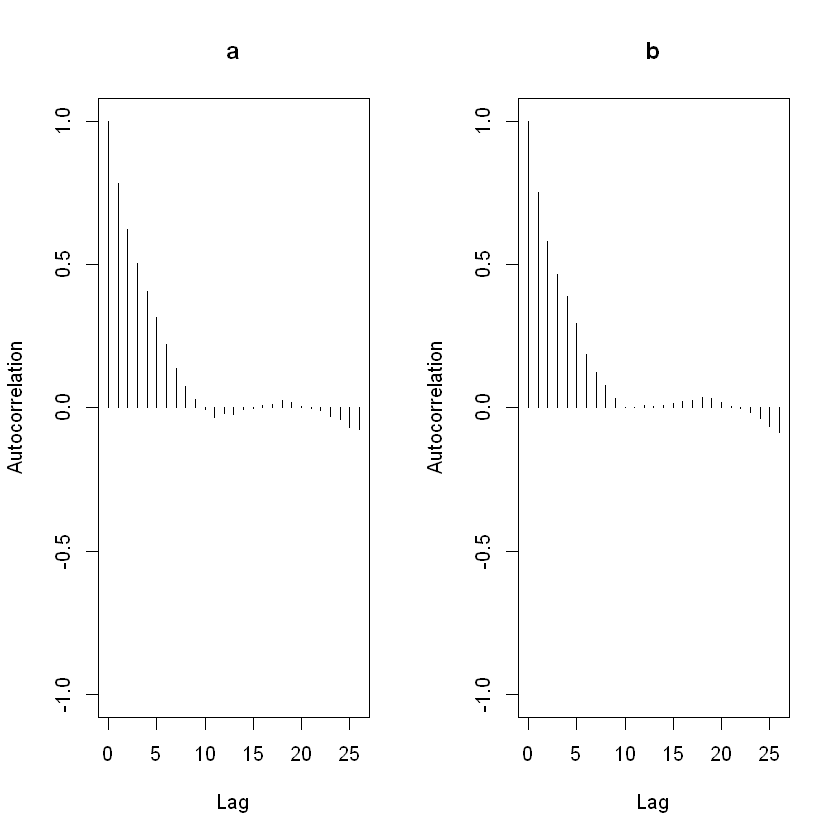

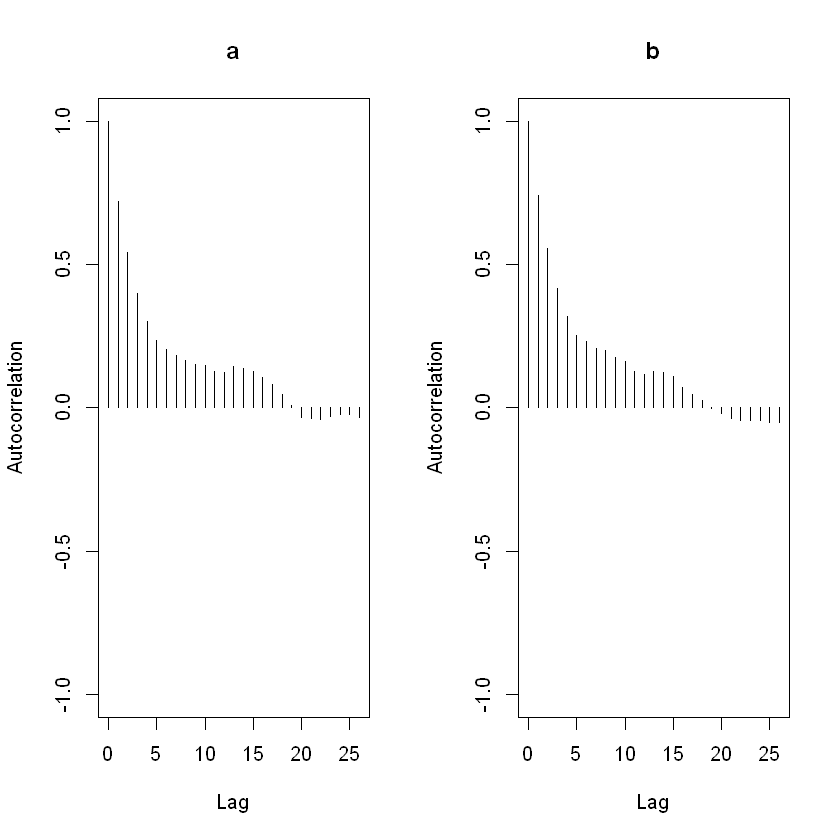

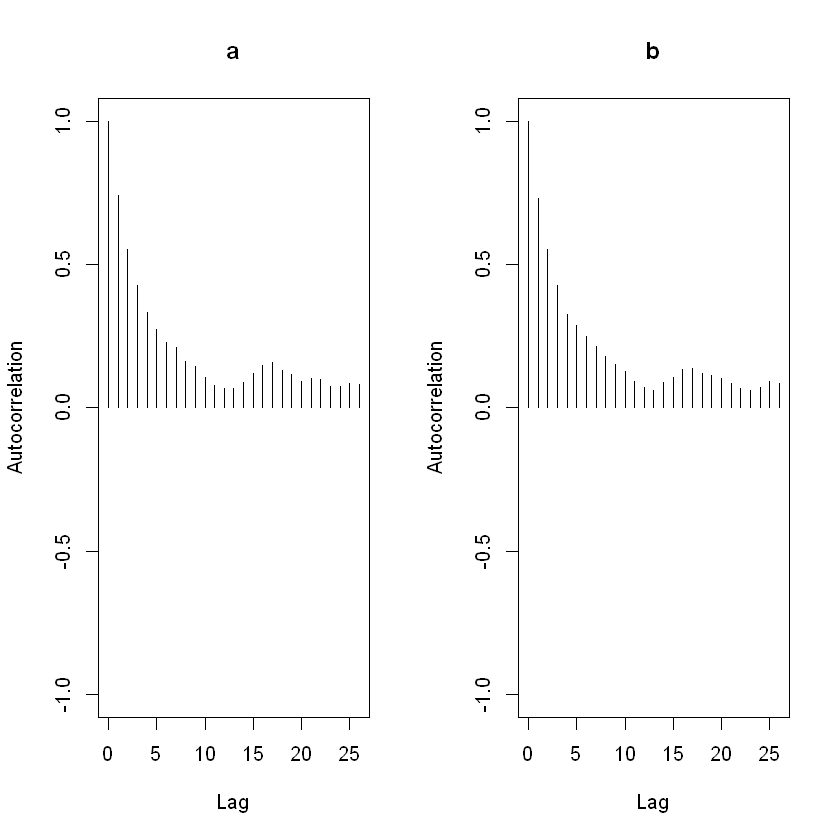

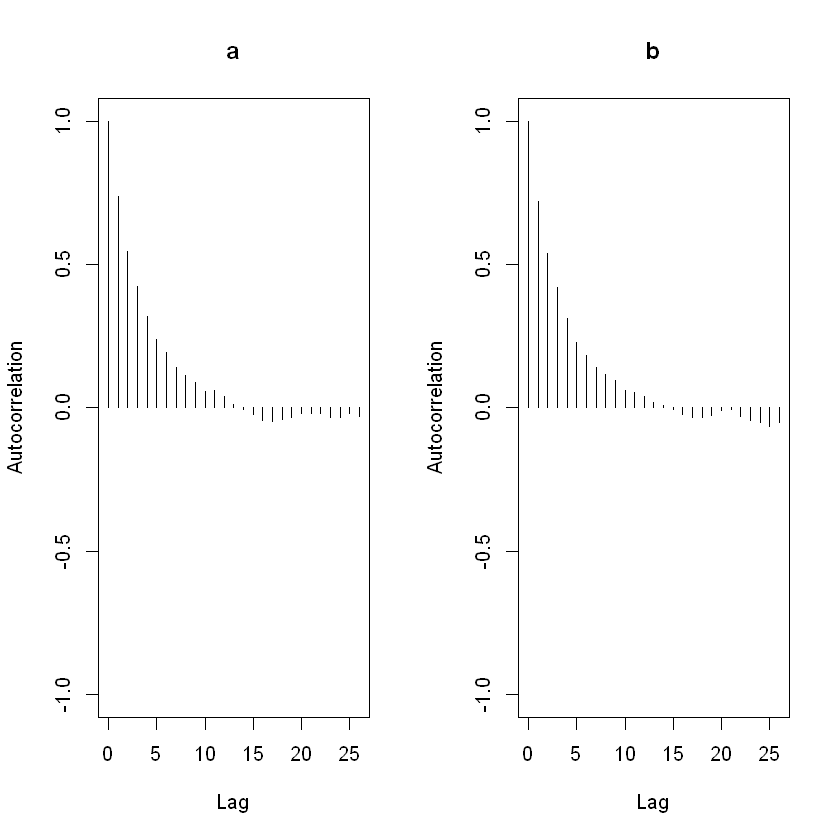

In [18]:
## Look at the autocorrelation of the chain
autocorr.diag(samples)
autocorr.plot(samples)

In [19]:
## What is the effective size of the sample?
effectiveSize(samples) 
rejectionRate(samples)

a        b 
567.0735 577.9427

a b 
0 0

$$p(x; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(x)} x^{-\alpha - 1} \exp\bigg(-\frac{\beta}{x}\bigg)$$

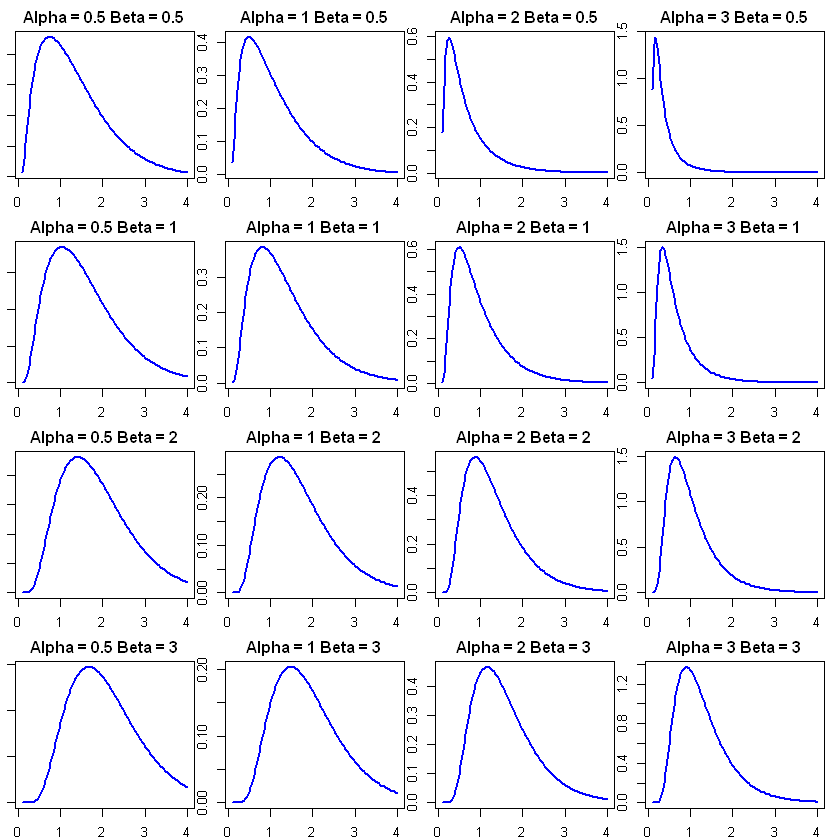

In [20]:
dinvgamma = function(alpha, beta, x){
    (beta^alpha / gamma(x)) * x^(-alpha - 1) * exp(-beta / x)
}

## Setup plot options
par(mfrow = c(4,4), mar=c(2,1,2,1)) # mar = c(bottom, left, top, right)

x = seq(from = 0.1, to = 4, length.out = 100)
alphas = c(0.5, 1.0, 2.0, 3.0)
betas = c(0.5, 1.0, 2.0, 3.0)
for(b in betas){
    for(a in alphas){
        title = paste('Alpha =', a, 'Beta =', b)
        ys = sapply(x, function(y) dinvgamma(a, b, y))
        plot(x, ys, type = 'l', lty = 1, lwd = 2, col = 'blue',
            main = title)
    }
}

# Set plot options back to normal
par(mar=c(5.1,4.1,4.1,2.1), mfrow=c(1,1))

In [21]:
read.auto = function(file = 'Automobile price data _Raw_.csv'){
  ## Read the csv file
  auto.price <- read.csv(file, header = TRUE, 
                      stringsAsFactors = FALSE)

  ## Coerce some character columns to numeric
  numcols <- c('price', 'bore', 'stroke', 'horsepower', 'peak.rpm')
  auto.price[, numcols] <- lapply(auto.price[, numcols], as.numeric)

  ## Remove cases or rows with missing values. In this case we keep the 
  ## rows which do not have nas. 
  auto.price[complete.cases(auto.price), ]
}
auto.price = read.auto()
names(auto.price)

Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"Warning message in lapply(auto.price[, numcols], as.numeric):
"NAs introduced by coercion"

[1] "symboling"         "normalized.losses" "make"             
 [4] "fuel.type"         "aspiration"        "num.of.doors"     
 [7] "body.style"        "drive.wheels"      "engine.location"  
[10] "wheel.base"        "length"            "width"            
[13] "height"            "curb.weight"       "engine.type"      
[16] "num.of.cylinders"  "engine.size"       "fuel.system"      
[19] "bore"              "stroke"            "compression.ratio"
[22] "horsepower"        "peak.rpm"          "city.mpg"         
[25] "highway.mpg"       "price"

In [22]:
col.list = c('curb.weight', 'engine.size')
X = as.matrix(auto.price[, col.list])
y = as.matrix(log(auto.price[, 'price']))
str(X)
str(y)

 int [1:195, 1:2] 2548 2548 2823 2337 2824 2507 2844 2954 3086 2395 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:195] "1" "2" "3" "4" ...
  ..$ : chr [1:2] "curb.weight" "engine.size"
 num [1:195, 1] 9.51 9.71 9.71 9.54 9.77 ...


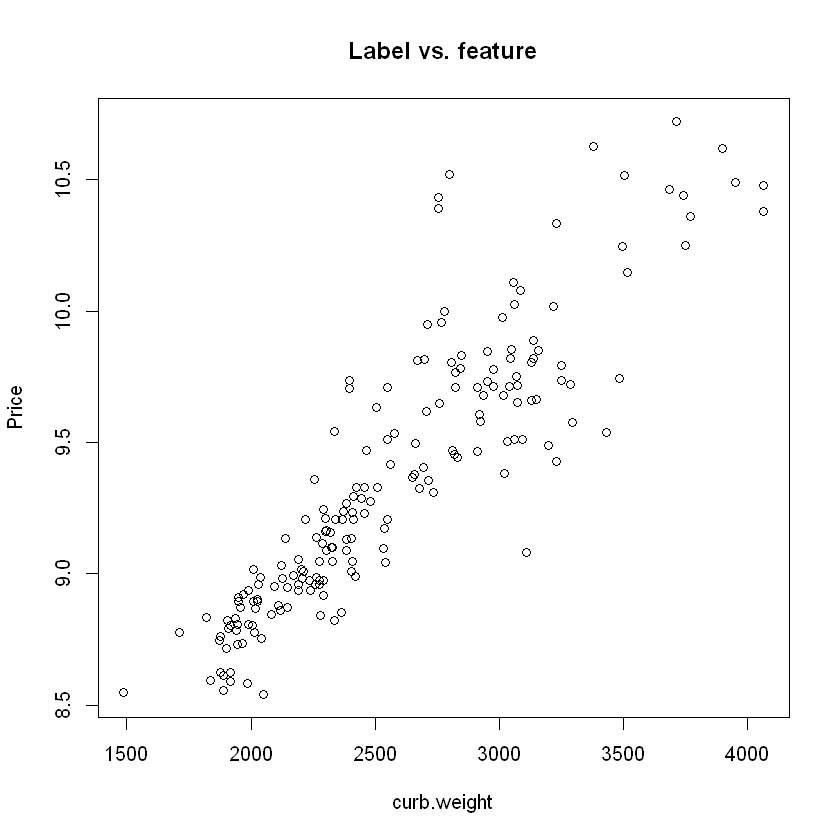

[[1]]
NULL

[[2]]
NULL

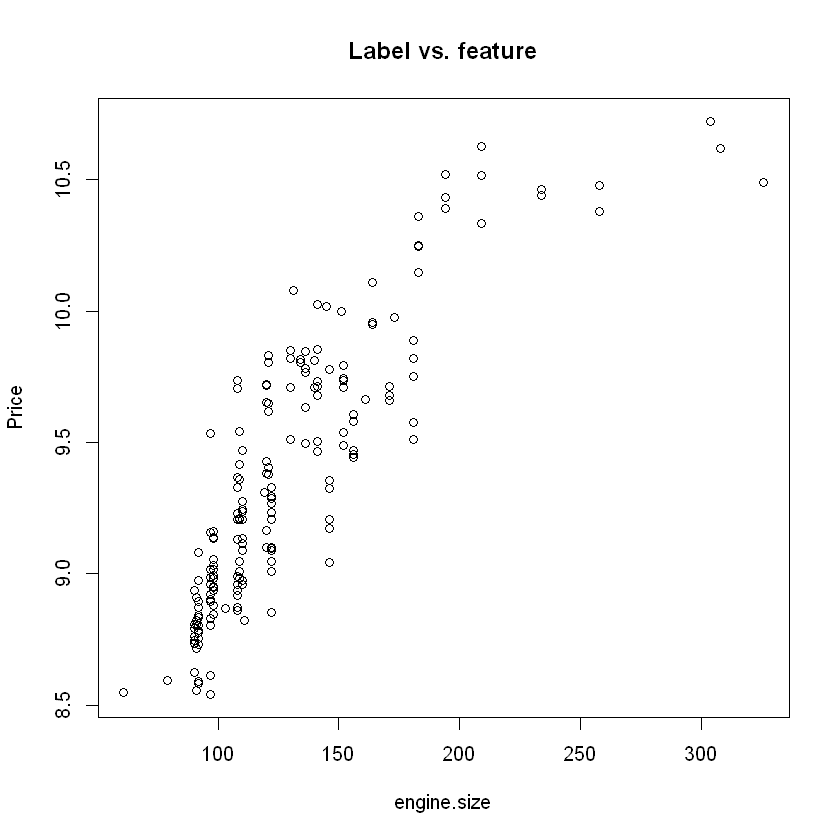

In [23]:
lapply(col.list, function(x) plot(X[,x], y, main = 'Label vs. feature',
    xlab = x, ylab = 'Price'))

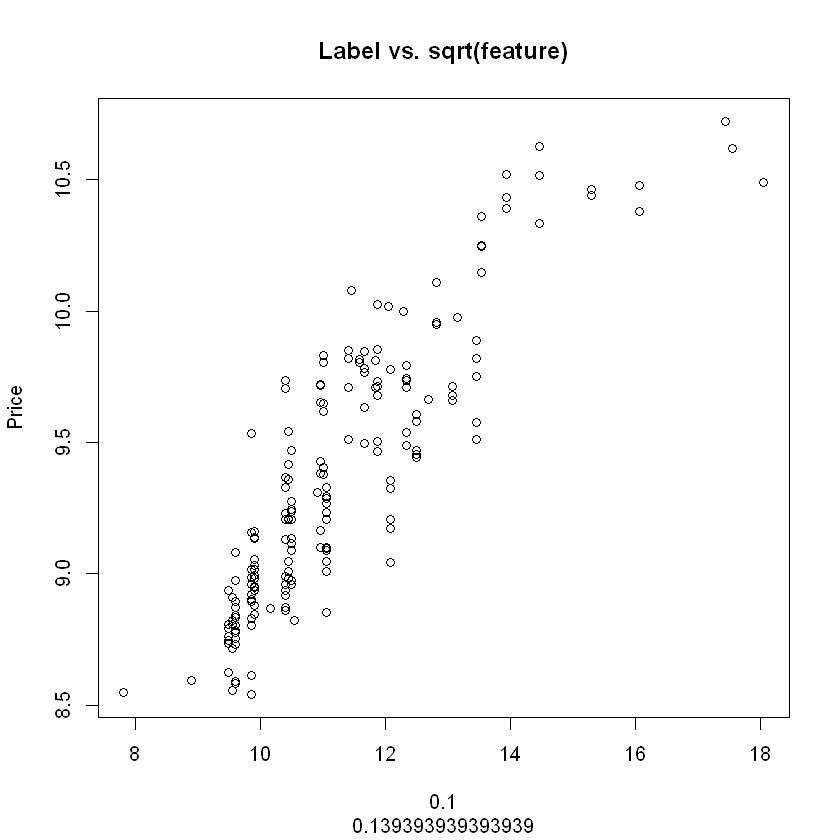

In [24]:
## Transform engine size
X[, 'engine.size'] = sqrt(X[, 'engine.size'])
plot(X[,'engine.size'],  y, main = 'Label vs. sqrt(feature)',
    xlab = x, ylab = 'Price')

In [25]:
## Linear model for comparison
modlm = lm(y ~ ., data = data.frame(X))
summary(modlm)


Call:
lm(formula = y ~ ., data = data.frame(X))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.43903 -0.13918 -0.01520  0.09683  0.71542 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 6.648e+00  1.072e-01  62.011  < 2e-16 ***
curb.weight 5.368e-04  6.032e-05   8.900 4.19e-16 ***
engine.size 1.186e-01  1.905e-02   6.228 2.91e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2084 on 192 degrees of freedom
Multiple R-squared:  0.8341,	Adjusted R-squared:  0.8323 
F-statistic: 482.5 on 2 and 192 DF,  p-value: < 2.2e-16


#### Copyright 2017, Stephen F Elston. All rights reserved. 